In [7]:
# Standard library imports
import sys
import os
import time
import warnings

from utils import pinns, plotting

# Determine the current directory of this script
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, 'utils/')

# Change the working directory to the script's directory
os.chdir(current_dir)

# Modify the module search path to include utilities directory
sys.path.insert(0, utilities_dir)

# Now import the pinns module
import importlib
importlib.reload(pinns)
importlib.reload(plotting)
from pinns import *  # Importing Physics Informed Neural Networks utilities
from plotting import *  # Importing custom plotting utilities

# Import third-party libraries
import torch  # PyTorch library for deep learning
import torch.nn as nn  # Neural network module in PyTorch
import numpy as np  # NumPy library for numerical operations
import scipy.io as sp  # SciPy module for MATLAB file I/O
import matplotlib.pyplot as plt  # Matplotlib for plotting

# Import additional utilities
from functools import partial  # Higher-order functions and operations on callable objects
from pyDOE import lhs  # Design of experiments for Python, including Latin Hypercube Sampling


# Linear elasticity 

\begin{align}
\nabla \cdot \boldsymbol{\sigma} + \mathbf{F} &= 0, \tag{7} \\[6pt]
\boldsymbol{\varepsilon} &= \tfrac{1}{2} \left[ \nabla \mathbf{u} + (\nabla \mathbf{u})^{T} \right], \tag{8} \\[6pt]
\boldsymbol{\sigma} &= \mathbf{C} : \boldsymbol{\varepsilon}. \tag{9}
\end{align}

where:

- $\mathbf{u} = (u, v)$: displacement field.  
- $\boldsymbol{\varepsilon}$: strain tensor.  
- $\boldsymbol{\sigma}$: stress tensor.  
- $\mathbf{C}$: constitutive tensor of the material (Hooke's law).  
- $\mathbf{F}$: body force vector.  
- $\rho$: material density.  
- $\mathbf{u}_{tt}$: acceleration of the displacement field.  

---

For 2D linear elasticity, the equilibrium equations are:

$$
\begin{aligned}
\frac{\partial \sigma_{xx}}{\partial x} + \frac{\partial \sigma_{xy}}{\partial y} &= 0, \\
\frac{\partial \sigma_{xy}}{\partial x} + \frac{\partial \sigma_{yy}}{\partial y} &= 0.
\end{aligned}
$$

The PDE loss penalizes the residuals of these equations at the collocation points $(x_i, y_i)$:

$$
\mathcal{L}_{\text{PDE}} =
\frac{1}{N} \sum_{i=1}^{N}
\left[
\left(\frac{\partial \sigma_{xx}}{\partial x_i} + \frac{\partial \sigma_{xy}}{\partial y_i}\right)^2
+
\left(\frac{\partial \sigma_{xy}}{\partial x_i} + \frac{\partial \sigma_{yy}}{\partial y_i}\right)^2
\right]
$$

The stress components are related to the strain tensor through Hooke’s law:

$$
\begin{aligned}
\sigma_{xx} &= \lambda (\varepsilon_{xx} + \varepsilon_{yy}) + 2\mu \varepsilon_{xx}, \\
\sigma_{yy} &= \lambda (\varepsilon_{xx} + \varepsilon_{yy}) + 2\mu \varepsilon_{yy}, \\
\sigma_{xy} &= 2\mu \varepsilon_{xy},
\end{aligned}
$$

with Lamé constants:

$$
\lambda = \frac{E \nu}{(1+\nu)(1-2\nu)}, \qquad \mu = \frac{E}{2(1+\nu)}.
$$

The strains are computed from the displacements $u(x,y)$ and $v(x,y)$:

$$
\varepsilon_{xx} = \frac{\partial u}{\partial x}, \quad
\varepsilon_{yy} = \frac{\partial v}{\partial y}, \quad
\varepsilon_{xy} = \tfrac{1}{2}\left(\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}\right).
$$

---

If displacements are prescribed on the boundary (Dirichlet BCs):

$$
u(x,y) = u_b(x,y), \qquad v(x,y) = v_b(x,y),
$$

then the boundary loss is defined as:

$$
\mathcal{L}_{\text{Dirichlet}} =
\frac{1}{N_b} \sum_{i=1}^{N_b}
\left[
(u(x_i, y_i) - u_b(x_i, y_i))^2 +
(v(x_i, y_i) - v_b(x_i, y_i))^2
\right].
$$

---

For tractions prescribed on a boundary (Neumann BCs):

$$
\boldsymbol{\sigma}(x, y) \cdot \mathbf{n}(x, y) = \mathbf{t}_b(x, y),
$$

where  $\mathbf{n}$ is the outward normal vector and $\mathbf{t}_b$ is the prescribed traction vector.

For vertical sides ($x=0$ and $x=L$):

$$
\mathbf{n} = (\pm 1, 0),
$$

so that:

$$
\sigma_{xx} = 0, \quad \sigma_{xy} = 0.
$$

The Neumann loss penalizes deviations from the prescribed tractions at the boundary points $(x_i, y_i)$:

$$
\mathcal{L}_{\text{Neumann}} =
\frac{1}{N_N}
\sum_{i=1}^{N_N}
\left[
(\sigma_{xx}(x_i, y_i) n_x + \sigma_{xy}(x_i, y_i) n_y - t_{b,x})^2 +
(\sigma_{xy}(x_i, y_i) n_x + \sigma_{yy}(x_i, y_i) n_y - t_{b,y})^2
\right].
$$

For the traction-free sides ($\mathbf{t}_b = 0$), this simplifies to:

$$
\mathcal{L}_{\text{Neumann}} =
\frac{1}{N_{\text{sides}}}
\sum_{i\in\Gamma_{\text{left}}\cup\Gamma_{\text{right}}}
\left[
\sigma_{xx}(x_i, y_i)^2 + \sigma_{xy}(x_i, y_i)^2
\right].
$$

---

Combining all terms, the final loss minimized by the PINN is:

$$
\boxed{
\mathcal{L}_{\text{total}} =
w_{\text{PDE}} \, \mathcal{L}_{\text{PDE}}
+ w_{\text{D}} \, \mathcal{L}_{\text{Dirichlet}}
+ w_{\text{N}} \, \mathcal{L}_{\text{Neumann}}
}
$$

where $w_{\text{PDE}}$ and $w_{\text{BC}}$ are weighting coefficients that balance the contribution of each loss component.
 
---

# Square Plate with Fixed Bottom and Top Displacement

 
- **Bottom (y=0):** Fixed → $u$=$v$=0  
- **Top (y=L):** Prescribed vertical displacement $v=V_{0, u}$ free  
- **Left/Right (x=0, x=L):** Free (no traction, σ·$n$=0)

![Boundary conditions for square plate](square_plate.svg)


# Loss Functions

## PDE Loss

For collocation points  
$$
(x_i, y_i) \in \Omega,
$$ 
the PDE loss measures how well the stress field satisfies equilibrium:

$$
L_{\text{PDE}} = \frac{1}{N_\Omega} \sum_{i=1}^{N_\Omega} 
\left[ R_x(x_i, y_i)^2 + R_y(x_i, y_i)^2 \right],
$$

where the residuals are defined as:

$$
R_x = \frac{\partial \sigma_{xx}}{\partial x} + \frac{\partial \sigma_{xy}}{\partial y}, 
\quad
R_y = \frac{\partial \sigma_{xy}}{\partial x} + \frac{\partial \sigma_{yy}}{\partial y}.
$$

---

## Boundary Condition (BC) Loss
 
Applied at the bottom boundary (fixed displacement) and the vertical component at the top boundary (prescribed displacement):

$$
L_{\text{BCD}} = 
\frac{1}{N_{\text{bot}}} 
\sum_{i \in \Gamma_{\text{bot}}}
\left[
(u - u_b)^2 + (v - v_b)^2
\right]
+
\frac{1}{N_{\text{top}}} 
\sum_{i \in \Gamma_{\text{top}}}
\left[
(v - v_t)^2
\right],
$$

with prescribed displacements:

$$
u_b  = 0, 
\quad 
v_b  = 0 
\quad \text{(bottom boundary)},
$$

$$
v_t  = V_0 
\quad \text{(top boundary)}.
$$

---

$$
L_{\text{BCN}} = 
\frac{1}{N_{\text{sides}}}
\sum_{i \in \Gamma_{\text{left}} \cup \Gamma_{\text{right}}}
\left[
(\sigma(x_i, y_i) \cdot n)_x^2 +
(\sigma(x_i, y_i) \cdot n)_y^2
\right],
$$

where for lateral sides, the outward normal vector is:

$$
n = (\pm 1, 0).
$$

Thus, this condition is equivalent to enforcing:

$$
\sigma_{xx}^2 + \sigma_{xy}^2 = 0
\quad \text{on } \Gamma_{\text{left}}, \Gamma_{\text{right}}.
$$

---

## Total Loss Function 

The total loss combines all contributions with balancing weights:

$$
L_{\text{total}} = 
w_{\text{PDE}} \, L_{\text{PDE}} +
w_D \, L_{\text{BCD}} +
w_N \, L_{\text{BCN}}.
$$
---

# Neural Network Definition

$$
\textbf{Arquitectura de la red } \texttt{PINN\_Elasticity2D}:
$$

$$
\begin{array}{ll}
\text{Entradas:} & x,\, y \\[6pt]
\text{Salidas:} & u(x,y),\, v(x,y) \\[6pt]
\text{Número de capas:} & 4 \\[6pt]
\text{Estructura:} &
2 \;\longrightarrow\; 50 \;\longrightarrow\; 50 \;\longrightarrow\; 50 \;\longrightarrow\; 2 \\[6pt]
\text{Función de activación:} & \tanh
\end{array}
$$

In [8]:
class PINN_Elasticity2D(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
    
    def forward(self, x, y):
        X = torch.cat([x, y], dim=1)
        for i in range(len(self.layers)-1):
            X = self.activation(self.layers[i](X))
        X = self.layers[-1](X)
        u, v = X[:,0:1], X[:,1:2]
        return u, v

# Physical Parameters


In [9]:
E = 0.20       # Young's modulus — 1e0 (soft materials) to 1e5 (stiff materials)
nu = 0.3        # Poisson's ratio — 0.2 and 0.45  
L = 1.0       # Plate length
V0 = 0.5      # Top boundary vertical displacement

# Lame constants
lam = E*nu / ((1+nu)*(1-2*nu))
mu  = E / (2*(1+nu))

# Sampling Points

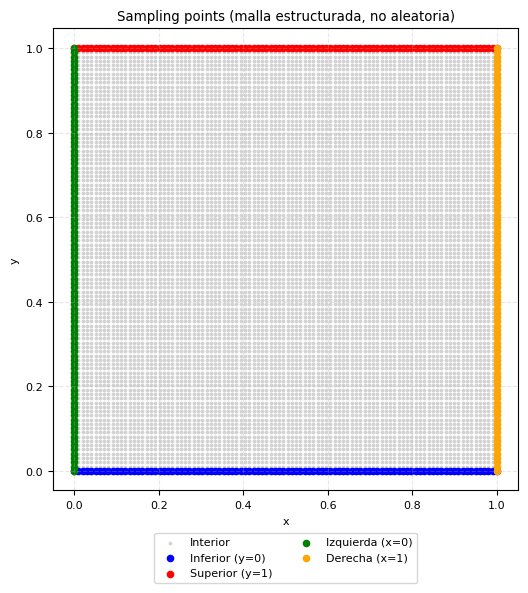

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Parámetros de la malla
N_side = 100     # número de puntos por eje (interior)
N_bnd  = 100     # puntos por borde

# -----------------------------
# Puntos interiores (malla regular)
# -----------------------------
x_vals = torch.linspace(0, 1, N_side)
y_vals = torch.linspace(0, 1, N_side)
X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')

x_int = X.flatten().view(-1, 1)
y_int = Y.flatten().view(-1, 1)
# dejar estos tensores con requires_grad_ sólo si los vas a usar en autograd
x_int.requires_grad_(True)
y_int.requires_grad_(True)

# -----------------------------
# Puntos en los bordes (no aleatorio)
# -----------------------------
# Inferior (y=0)
x_bot = torch.linspace(0, 1, N_bnd).view(-1, 1)
y_bot = torch.zeros_like(x_bot)

# Superior (y=1)
x_top = torch.linspace(0, 1, N_bnd).view(-1, 1)
y_top = torch.ones_like(x_top)

# Lados izquierdo y derecho: definimos y_side y luego x_left/x_right
y_side = torch.linspace(0, 1, N_bnd).view(-1, 1)   # <-- definido correctamente
x_left  = torch.zeros_like(y_side)
x_right = torch.ones_like(y_side)

# Si vas a usar estos puntos para autograd (derivadas en fronteras), activas requires_grad_
x_bot.requires_grad_(True); y_bot.requires_grad_(True)
x_top.requires_grad_(True); y_top.requires_grad_(True)
x_left.requires_grad_(True); y_side.requires_grad_(True)
x_right.requires_grad_(True)

# -----------------------------
# Convertir a NumPy para graficar
# -----------------------------
x_int_np, y_int_np = x_int.detach().numpy(), y_int.detach().numpy()
x_bot_np, y_bot_np = x_bot.detach().numpy(), y_bot.detach().numpy()
x_top_np, y_top_np = x_top.detach().numpy(), y_top.detach().numpy()
x_left_np, y_left_np = x_left.detach().numpy(), y_side.detach().numpy()
x_right_np, y_right_np = x_right.detach().numpy(), y_side.detach().numpy()

# -----------------------------
# Graficar el muestreo
# -----------------------------
plt.figure(figsize=(6,6))
plt.scatter(x_int_np, y_int_np, s=3, c='lightgray', label='Interior')
plt.scatter(x_bot_np, y_bot_np, s=20, c='blue', label='Inferior (y=0)')
plt.scatter(x_top_np, y_top_np, s=20, c='red', label='Superior (y=1)')
plt.scatter(x_left_np, y_left_np, s=20, c='green', label='Izquierda (x=0)')
plt.scatter(x_right_np, y_right_np, s=20, c='orange', label='Derecha (x=1)')

plt.title("Sampling points (malla estructurada, no aleatoria)")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2)
plt.axis('equal')
plt.xlim(-0.05, 1.05); plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


# Physics Functions

In [11]:
def compute_strains(u, v, x, y):
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dy = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    dv_dx = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    dv_dy = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    
    eps_xx = du_dx
    eps_yy = dv_dy
    eps_xy = 0.5*(du_dy + dv_dx)
    return eps_xx, eps_yy, eps_xy

def compute_stresses(eps_xx, eps_yy, eps_xy):
    sigma_xx = lam*(eps_xx + eps_yy) + 2*mu*eps_xx
    sigma_yy = lam*(eps_xx + eps_yy) + 2*mu*eps_yy
    sigma_xy = 2*mu*eps_xy
    return sigma_xx, sigma_yy, sigma_xy

def equilibrium_residual(u, v, x, y):
    eps_xx, eps_yy, eps_xy = compute_strains(u, v, x, y)
    sigma_xx, sigma_yy, sigma_xy = compute_stresses(eps_xx, eps_yy, eps_xy)
    
    dsxx_dx = torch.autograd.grad(sigma_xx, x, grad_outputs=torch.ones_like(sigma_xx), create_graph=True)[0]
    dsxy_dy = torch.autograd.grad(sigma_xy, y, grad_outputs=torch.ones_like(sigma_xy), create_graph=True)[0]
    dsxy_dx = torch.autograd.grad(sigma_xy, x, grad_outputs=torch.ones_like(sigma_xy), create_graph=True)[0]
    dsyy_dy = torch.autograd.grad(sigma_yy, y, grad_outputs=torch.ones_like(sigma_yy), create_graph=True)[0]
    
    R1 = dsxx_dx + dsxy_dy
    R2 = dsxy_dx + dsyy_dy
    return R1, R2


# Loss Functions

In [12]:
def loss_pde(model, x, y):
    u, v = model(x, y)
    R1, R2 = equilibrium_residual(u, v, x, y)
    return torch.mean(R1**2 + R2**2)

def loss_bc_dirichlet(model):
    # Bottom: u=v=0
    u_b, v_b = model(x_bot, y_bot)
    L_bot = torch.mean(u_b**2 + v_b**2)
    
    # Top: v=V0, u free
    u_t, v_t = model(x_top, y_top)
    L_top = torch.mean((v_t - V0)**2)
    
    return L_bot + L_top

def loss_bc_neumann(model):
    # Left side (x=0): sigma_xx = sigma_xy = 0
    u_l, v_l = model(x_left, y_side)
    eps_xx, eps_yy, eps_xy = compute_strains(u_l, v_l, x_left, y_side)
    sxx, syy, sxy = compute_stresses(eps_xx, eps_yy, eps_xy)
    L_left = torch.mean(sxx**2 + sxy**2)
    
    # Right side (x=1): sigma_xx = sigma_xy = 0
    u_r, v_r = model(x_right, y_side)
    eps_xx, eps_yy, eps_xy = compute_strains(u_r, v_r, x_right, y_side)
    sxx, syy, sxy = compute_stresses(eps_xx, eps_yy, eps_xy)
    L_right = torch.mean(sxx**2 + sxy**2)
    
    return L_left + L_right

# Training Loop

In [13]:
model = PINN_Elasticity2D([2, 40, 40, 40, 2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

w_pde, w_bcD, w_bcN = 1.0, 10.0, 10.0
epochs = 5000

for epoch in range(epochs):
    optimizer.zero_grad()
    L_pde = loss_pde(model, x_int, y_int)
    L_bcD = loss_bc_dirichlet(model)
    L_bcN = loss_bc_neumann(model)
    loss_total = w_pde*L_pde + w_bcD*L_bcD + w_bcN*L_bcN
    loss_total.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: L_total={loss_total.item():.3e}, PDE={L_pde.item():.3e}, BC_D={L_bcD.item():.3e}, BC_N={L_bcN.item():.3e}")


Epoch 0: L_total=4.042e+00, PDE=3.523e-05, BC_D=4.040e-01, BC_N=1.464e-04
Epoch 500: L_total=1.467e-02, PDE=1.840e-03, BC_D=6.592e-04, BC_N=6.234e-04
Epoch 1000: L_total=4.592e-03, PDE=1.144e-03, BC_D=1.085e-04, BC_N=2.364e-04
Epoch 1500: L_total=3.582e-03, PDE=1.002e-03, BC_D=9.519e-05, BC_N=1.628e-04
Epoch 2000: L_total=3.268e-03, PDE=9.230e-04, BC_D=8.488e-05, BC_N=1.496e-04
Epoch 2500: L_total=3.083e-03, PDE=9.271e-04, BC_D=7.509e-05, BC_N=1.405e-04
Epoch 3000: L_total=2.951e-03, PDE=9.158e-04, BC_D=6.942e-05, BC_N=1.341e-04
Epoch 3500: L_total=2.836e-03, PDE=8.734e-04, BC_D=6.494e-05, BC_N=1.313e-04
Epoch 4000: L_total=2.968e-03, PDE=8.005e-04, BC_D=8.445e-05, BC_N=1.323e-04
Epoch 4500: L_total=2.571e-03, PDE=7.285e-04, BC_D=6.029e-05, BC_N=1.239e-04


# Visualization

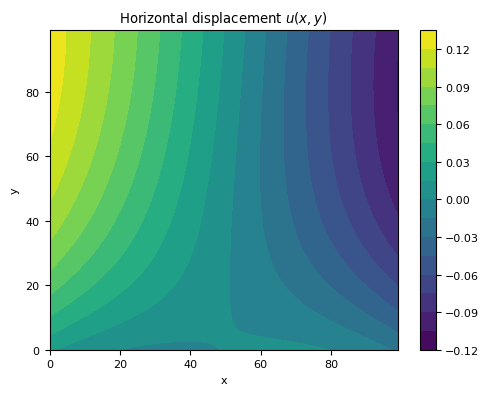

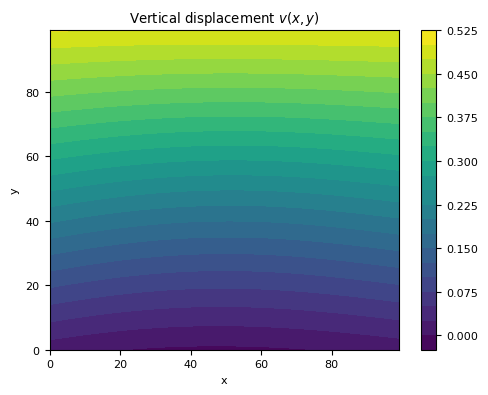

In [15]:
# Create grid for visualization
nx, ny = 100, 100
xv = np.linspace(0, 1, nx)
yv = np.linspace(0, 1, ny)
X, Y = np.meshgrid(xv, yv)

x_t = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1)
y_t = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1)

# Predict displacement field
with torch.no_grad():
    u_pred, v_pred = model(x_t, y_t)

U = u_pred.view(ny, nx).detach().numpy()
V = v_pred.view(ny, nx).detach().numpy()
disp_mag = np.sqrt(U**2 + V**2)

# Plot results with imshow
fig, ax = plt.subplots(figsize=(5, 4))

levels = 20  # number of contours (color levels)
im = ax.contourf(U, levels=levels, cmap='viridis')

ax.set_title("Horizontal displacement $u(x,y)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(5, 4))

im = ax.contourf(V, levels=levels, cmap='viridis')

ax.set_title("Vertical displacement $v(x,y)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
